In [1]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairs, CocoPairsNetwork
import matplotlib.pyplot as plt
from PIL import Image
from utils import run_websocket_server, run_http_server, plot_vector_field
import tensorflow as tf
sys.path.insert(0, os.path.abspath('..'))
# Import DeepExplain
from deepexplain.tf.v1_x import DeepExplain

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Using tf version = 1.15.0


In [2]:
# params 432, 368
w, h = 432, 368

image_path = './data/images/muscle.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image = common.read_imgfile(image_path, w, h)

In [3]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
# compute with and without 
humans_original = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

In [4]:
def get_index_on_line(peak_a, peak_b, steps=1000):
    indicies_on_line = []
    step_vec = (peak_b - peak_a) / float(steps)
    
    for i in range(steps):
        index = peak_a + i * step_vec
        index = np.ceil(index)
        indicies_on_line.append(index.astype(int))
    
    return indicies_on_line

def lies_between(A, B, C):
    a = np.linalg.norm(C - B)
    b = np.linalg.norm(C - A)
    c = np.linalg.norm(B - A)
    return a**2 + b**2 >= c**2 and a**2 + c**2 >= b**2

def get_index_near_line(data, p1, p2, distance=10):
    indicies_near_line = []
    for p3, value in np.ndenumerate(data):
        dist_to_line = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
        if dist_to_line < distance and lies_between(p3, p1, p2):
            indicies_near_line.append(p3)
    return indicies_near_line
    
def get_affected_pairs(index):
    return list(filter(lambda pair: pair[1][0] == index or pair[1][1] == index, enumerate(CocoPairs) ))
    
# position where to put the peak
def modify_right_wrist(change_id, estimator, pos_x = 40, pos_y = 60):
    # copy the required mats
    peaks = np.copy(estimator.peaks)
    heatMat = np.copy(estimator.heatMat)
    pafMat = np.copy(estimator.pafMat)
    eps = 0.0001
    print(f'Changing {change_id} part')

    ## CHANGE VLAUES OF THE PEAKS
    # change PAFs
    # find all affected PAF
    affected_pafs = get_affected_pairs(change_id)
    for (part_id, (peak_a_id, peak_b_id)) in affected_pafs:
        peak_id = peak_a_id if peak_b_id == change_id else peak_b_id
        
        # find the peak connect to the joint we want to move
        peak_y, peak_x = np.unravel_index(peaks[:, :, peak_id].argmax(), peaks[:, :, peak_id].shape)
        print(f'SET pos x: {pos_x}, y: {pos_y}')
        print(f'Peak pos x: {peak_x}, y: {peak_y}')
        
        vec = np.array([pos_x - peak_x, pos_y - peak_y]).astype('float64')
        vec /= np.linalg.norm(vec)
        if peak_a_id == change_id:
            vec *= -1.0
        print(f'Vec x: {vec[0]}, y: {vec[1]}')

        # compute the index on the line between the two points
        index_to_change = get_index_near_line(
            np.zeros(shape=pafMat.shape[:2]),
            np.array([peak_x, peak_y]),
            np.array([pos_x, pos_y]),
            1
        )

        # reset the PAF 
        # which paf in the network
        joint_id = CocoPairsNetwork[part_id]
        # set all values to zero
        pafMat[:,:, joint_id[0]] = np.zeros(shape=pafMat.shape[:2])
        pafMat[:,:, joint_id[1]] = np.zeros(shape=pafMat.shape[:2])

        # set only the required parts
        for (x, y) in index_to_change:
            pafMat[y, x, joint_id[0]] = vec[0]
            pafMat[y, x, joint_id[1]] = vec[1]

    # change heat
    # only one point is needed
    cur_heat_max_val = np.max(heatMat[:,:, change_id])
    heatMat[:,:, change_id] = np.zeros(shape=peaks.shape[:2])
    heatMat[pos_y, pos_x, change_id] = cur_heat_max_val + eps
    
    # change peak position
    cur_max = np.max(peaks[:,:, change_id])
    peaks[:,:, change_id] = np.zeros(shape=peaks.shape[:2])
    peaks[pos_y, pos_x, change_id] = cur_max + eps
    return peaks, heatMat, pafMat

COCO_id = CocoPart.RElbow.value
peaks, heatMat, pafMat = modify_right_wrist(COCO_id, e, 10, 50)
humans_modified = PoseEstimator.estimate_paf(peaks, heatMat, pafMat)

Changing 3 part
SET pos x: 10, y: 50
Peak pos x: 43, y: 24
Vec x: -0.7854916722275356, y: 0.6188722266035128
SET pos x: 10, y: 50
Peak pos x: 35, y: 35
Vec x: 0.8574929257125442, y: -0.5144957554275266


In [5]:
part = humans_original[0].body_parts[COCO_id]
print(f'ORIG: score: {part.score} x: {part.x} y: {part.y} ')
part = humans_modified[0].body_parts[COCO_id]
print(f'OCCULED: score: {part.score} x: {part.x} y: {part.y} ')


ORIG: score: 0.8124180436134338 x: 0.2037037037037037 y: 0.32608695652173914 
OCCULED: score: 0.8125180602073669 x: 0.09259259259259259 y: 0.5434782608695652 


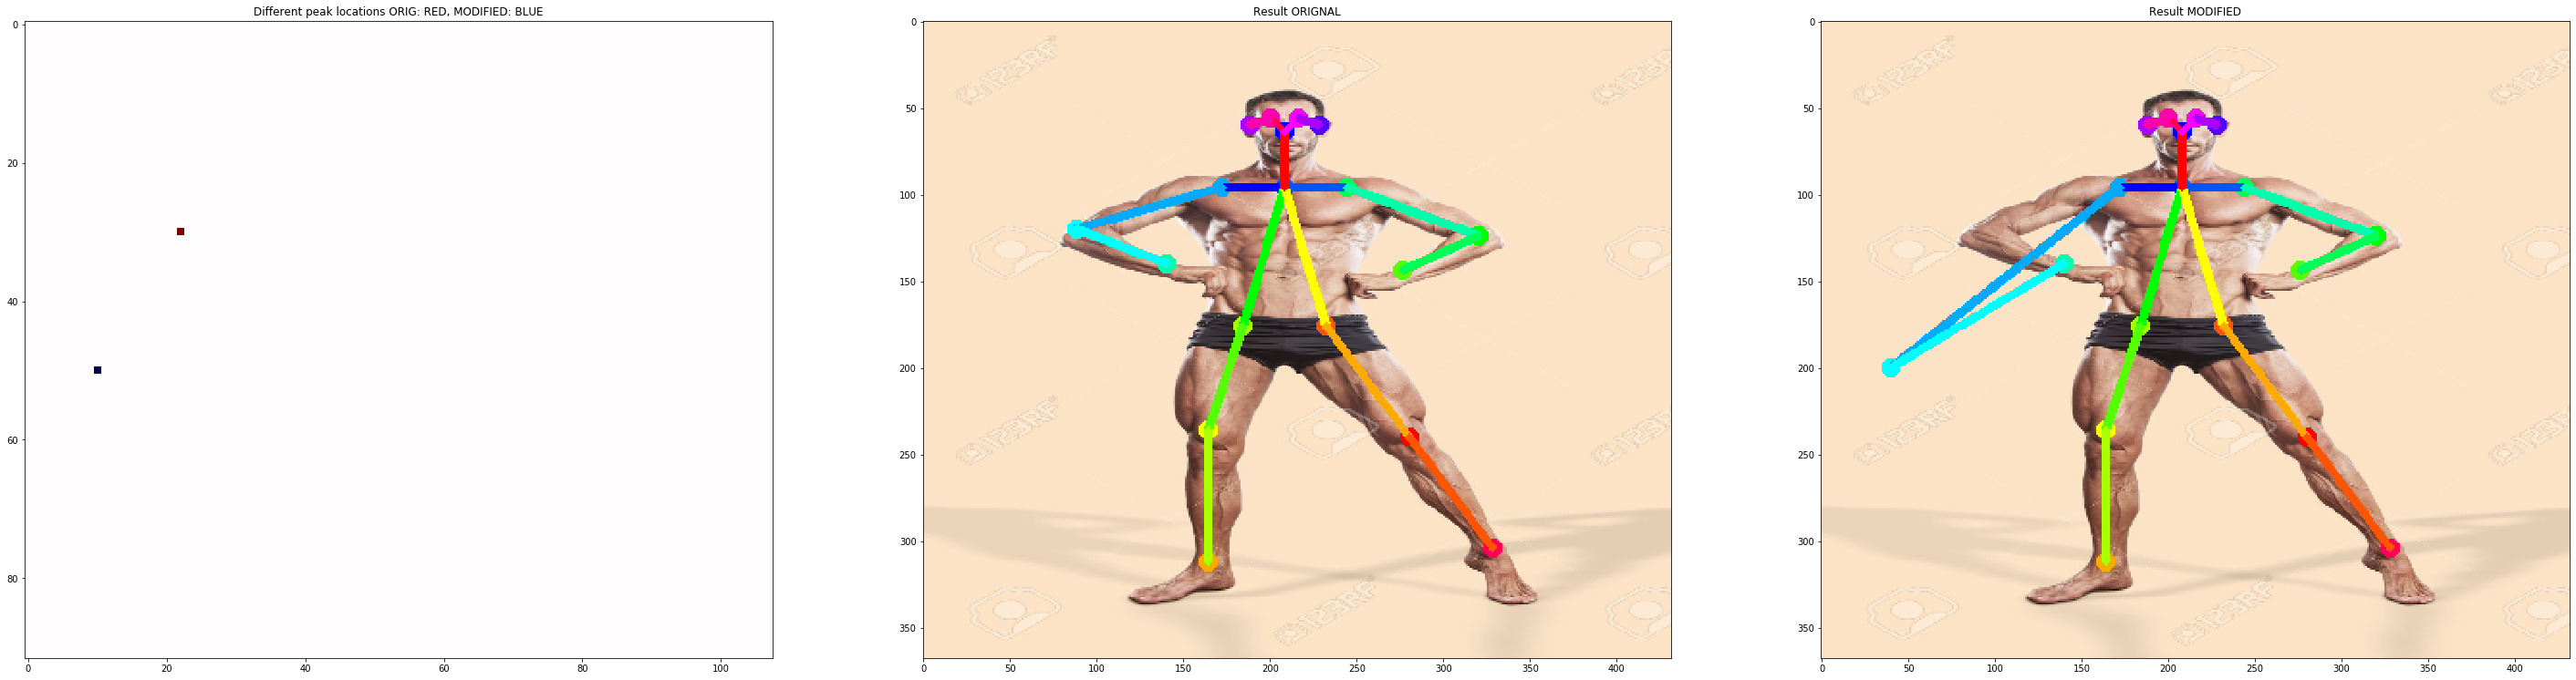

In [6]:
fig = plt.figure(figsize=(50, 25))
a = fig.add_subplot(1, 3,1)
a.set_title('Different peak locations ORIG: RED, MODIFIED: BLUE')
peak_orig = e.peaks[:, :, COCO_id]
peak_black = peaks[:, :, COCO_id]

comb_image = np.amax([peak_orig, peak_black], axis=0)
comb_image[comb_image == np.max(peak_orig)] = 1.0
comb_image[comb_image == np.max(peak_black)] = -1.0
a.imshow(comb_image, cmap=plt.cm.seismic )

#draw orig
a = fig.add_subplot(1,3,2)
image_result = TfPoseEstimator.draw_humans(image, humans_original, imgcopy=True)
a.set_title('Result ORIGNAL')
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))

# draw modified
a = fig.add_subplot(1, 3, 3)
image_result = TfPoseEstimator.draw_humans(image, humans_modified, imgcopy=True)
a.set_title('Result MODIFIED')
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))

Text(0.5, 1.0, 'MODIFIED HEATMAP')

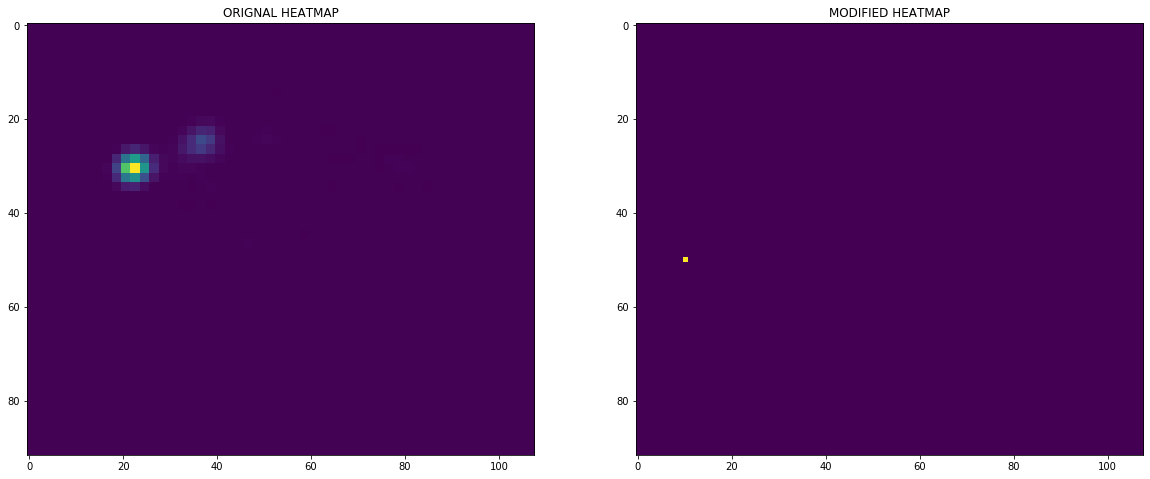

In [10]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(e.heatMat[:, :, COCO_id])
ax.set_title('ORIGNAL HEATMAP')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(heatMat[:, :, COCO_id])
ax.set_title('MODIFIED HEATMAP')

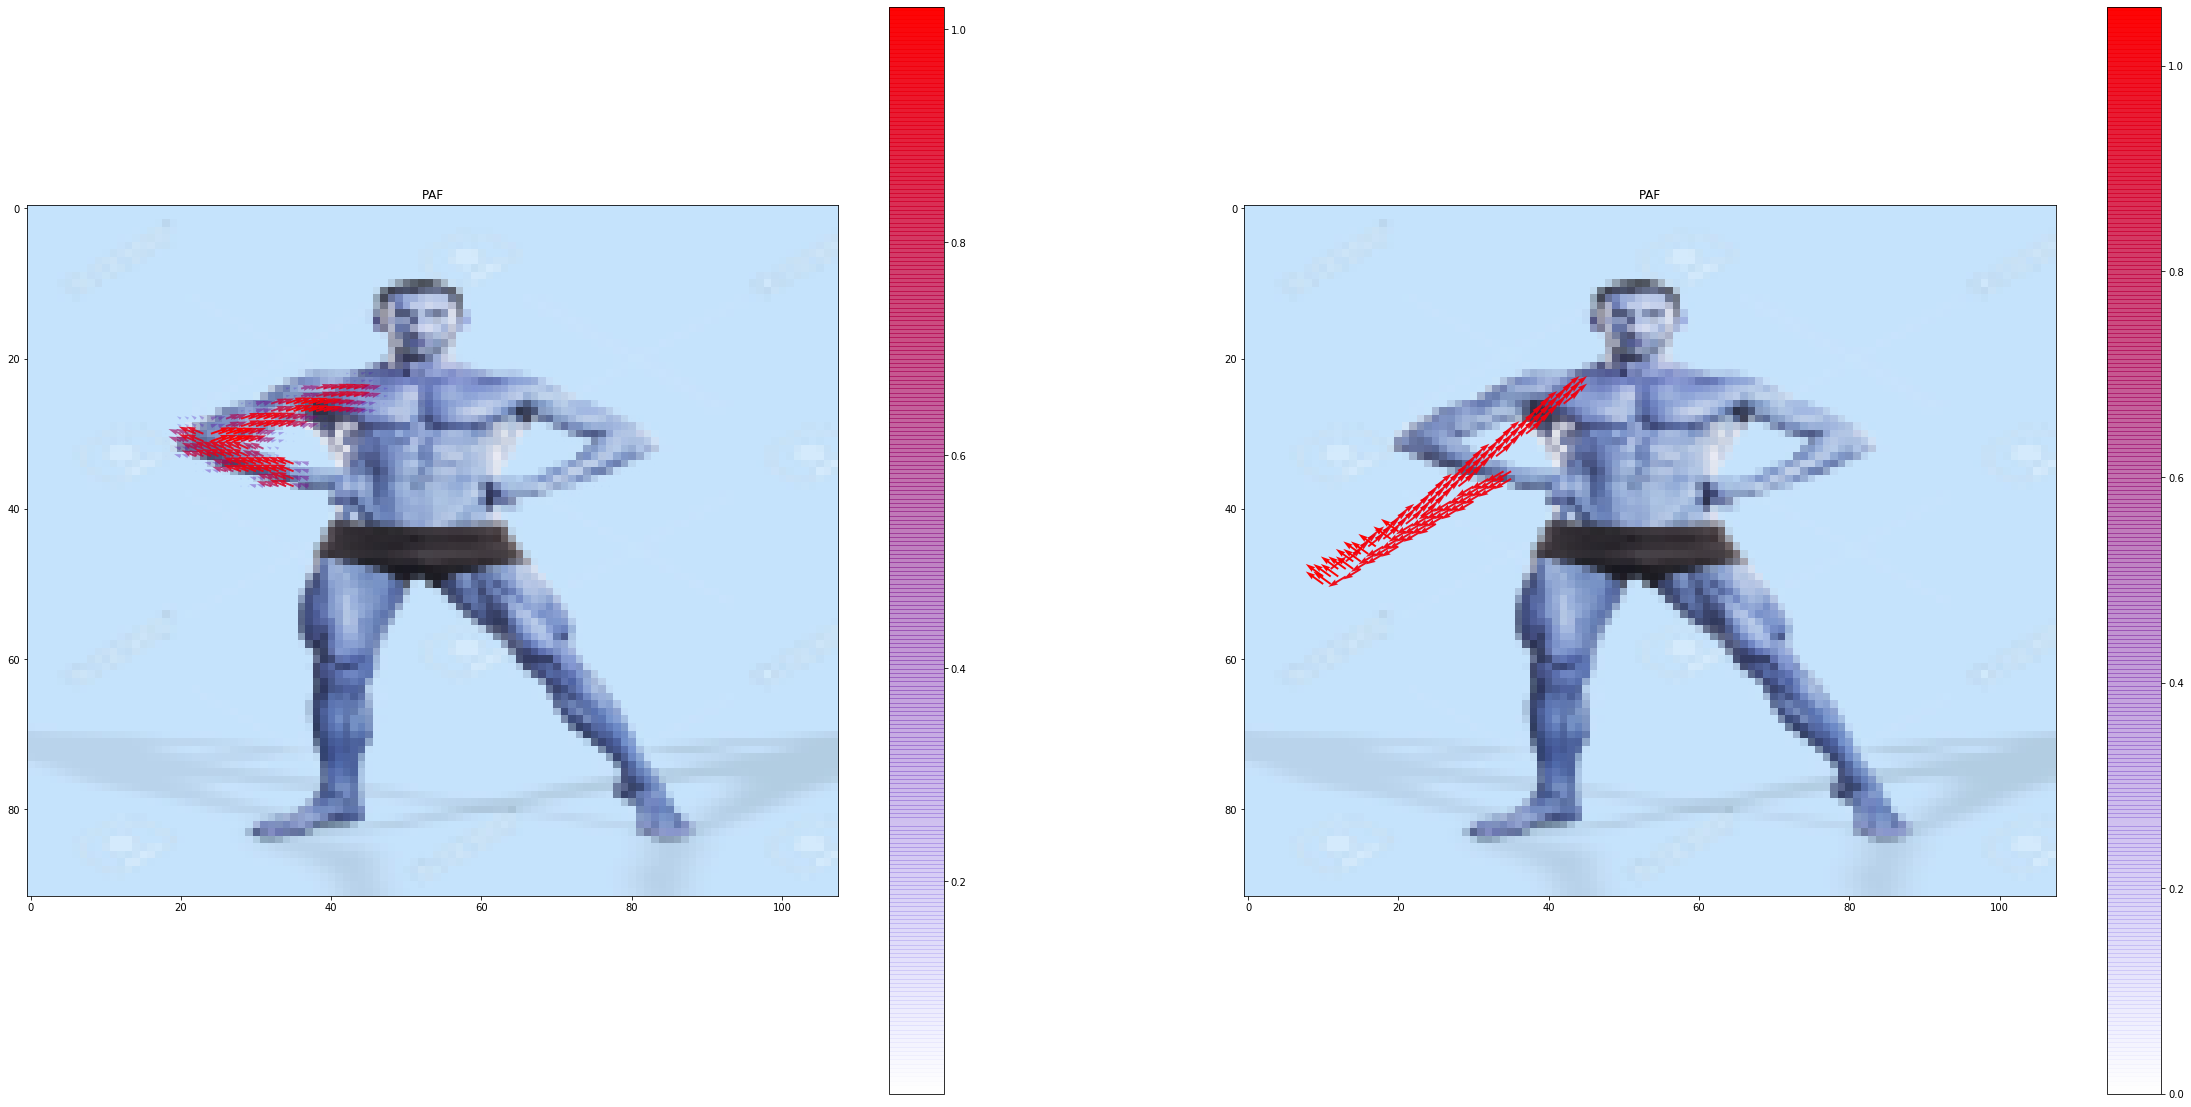

In [8]:
def get_UV(mats, change_id):
    U = []
    V = []
    affected_pafs = get_affected_pairs(change_id)
    for (part_id, (peak_a_id, peak_b_id)) in affected_pafs:
        joint_id = CocoPairsNetwork[part_id]

        U.append(np.copy(mats[:,:, joint_id[0]]) * (-1.0))
        V.append(np.copy(mats[:,:, joint_id[1]]))
    U = np.apply_along_axis(lambda x: max(x.min(), x.max(), key=abs), 0, U)
    V = np.apply_along_axis(lambda x: max(x.min(), x.max(), key=abs), 0, V)
    return U, V
    
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 2, 1)
bgimg = cv2.resize(image, (e.pafMat.shape[1], e.pafMat.shape[0]), interpolation=cv2.INTER_AREA)

U, V = get_UV(e.pafMat, COCO_id)
plot_vector_field(U, V, bgimg, ax, fig)

ax = fig.add_subplot(1, 2, 2)
U, V = get_UV(pafMat, COCO_id)
plot_vector_field(U, V, bgimg, ax, fig)